In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# ÏãúÏä§ÌÖúÏù¥ WindowsÏùº Í≤ΩÏö∞
if platform.system() == 'Windows':
    plt.rc('font', family='Pretendard')
# macOSÏùº Í≤ΩÏö∞ ÏòàÏãú:
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')

# ÎßàÏù¥ÎÑàÏä§ Î∂ÄÌò∏ Íπ®Ïßê Î∞©ÏßÄ
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 2. Ïã†Ïö©Ï†ïÎ≥¥
features_credit = [
    'ÏµúÏ¥àÌïúÎèÑÍ∏àÏï°',
    'Ïπ¥ÎìúÏù¥Ïö©ÌïúÎèÑÍ∏àÏï°', 'CAÌïúÎèÑÍ∏àÏï°',
    'ÏùºÏãúÏÉÅÌôòÎ°†ÌïúÎèÑÍ∏àÏï°', 'ÏõîÏÉÅÌôòÎ°†ÌïúÎèÑÍ∏àÏï°',
    'CAÏù¥ÏûêÏú®_Ìï†Ïù∏Ï†Ñ',
    'RVÏùºÏãúÎ∂àÏù¥ÏûêÏú®_Ìï†Ïù∏Ï†Ñ', 'RVÌòÑÍ∏àÏÑúÎπÑÏä§Ïù¥ÏûêÏú®_Ìï†Ïù∏Ï†Ñ',
    'RVÏïΩÏ†ïÏ≤≠Íµ¨Ïú®', 'RVÏµúÏÜåÍ≤∞Ï†úÎπÑÏú®',
    'ÌïúÎèÑÏ¶ùÏï°ÌöüÏàò_R12M',
    'ÌïúÎèÑÏ¶ùÏï°Í∏àÏï°_R12M', 'ÏÉÅÌñ•Í∞ÄÎä•CAÌïúÎèÑÍ∏àÏï°', 'ÏõîÏÉÅÌôòÎ°†ÏÉÅÌñ•Í∞ÄÎä•ÌïúÎèÑÍ∏àÏï°',
    'ÏùºÏãúÎ∂àONLYÏ†ÑÌôòÍ∞ÄÎä•Ïó¨Î∂Ä', 'ÌäπÎ≥ÑÌïúÎèÑÎ≥¥Ïú†Ïó¨Î∂Ä_R3M', 'Ïó∞Ï≤¥Í∞êÏï°Ïó¨Î∂Ä_R3M'
]

In [4]:
selected_feature=(
    features_credit)

In [5]:
print(len(selected_feature))         
print(type(selected_feature[0]))     
# 171 --> 119

17
<class 'str'>


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# 1. Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
df = pd.read_parquet("../../data/ÌÜµÌï©_train_Îç∞Ïù¥ÌÑ∞.parquet")

# 2. ÌîºÏ≤ò Î∞è ÌÉÄÍ≤ü Î∂ÑÎ¶¨
X = df[selected_feature].copy()
y = df["Segment"]

# 3. Î≤îÏ£ºÌòï Ïù∏ÏΩîÎî©
cat_cols = X.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# 4. Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨
X = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(X), columns=X.columns)

# Ïä§ÏºÄÏùºÎßÅ (DataFrame ÌòïÌÉú Ïú†ÏßÄ)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# ÎùºÎ≤®Ïù∏ÏΩîÎî©
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

# 6. train-validation Î∂ÑÌï†
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# 7. XGBoost Î™®Îç∏ ÏÑ†Ïñ∏ (GPU Í∞ÄÏÜç)
xgb_model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# 8. ÌïôÏäµ
xgb_model.fit(X_train, y_train)

# 9. ÏòàÏ∏° Î∞è ÌèâÍ∞Ä
y_pred = xgb_model.predict(X_val)
print(classification_report(y_val, y_pred))


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:08:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:08:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\core.py:2676: UserWarning: [16:08:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.s

              precision    recall  f1-score   support

           0       0.62      0.14      0.23       194
           1       1.00      0.07      0.13        29
           2       0.58      0.25      0.35     25518
           3       0.55      0.23      0.32     69848
           4       0.85      0.97      0.91    384411

    accuracy                           0.83    480000
   macro avg       0.72      0.33      0.39    480000
weighted avg       0.79      0.83      0.79    480000



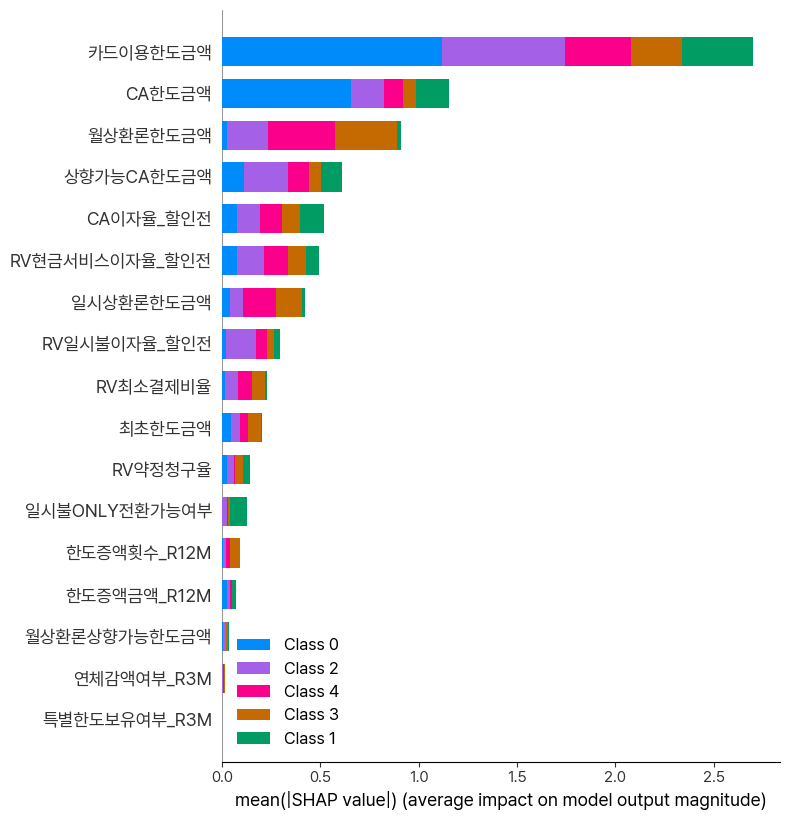

In [7]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, X_val, plot_type="bar")

In [8]:
import pandas as pd

importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

display(importance_df.head(30))

Feature  Importance
1         Ïπ¥ÎìúÏù¥Ïö©ÌïúÎèÑÍ∏àÏï°    0.155651
4         ÏõîÏÉÅÌôòÎ°†ÌïúÎèÑÍ∏àÏï°    0.122146
16      Ïó∞Ï≤¥Í∞êÏï°Ïó¨Î∂Ä_R3M    0.104856
12      ÏÉÅÌñ•Í∞ÄÎä•CAÌïúÎèÑÍ∏àÏï°    0.090545
5        CAÏù¥ÏûêÏú®_Ìï†Ïù∏Ï†Ñ    0.085628
2           CAÌïúÎèÑÍ∏àÏï°    0.069700
3        ÏùºÏãúÏÉÅÌôòÎ°†ÌïúÎèÑÍ∏àÏï°    0.066213
7   RVÌòÑÍ∏àÏÑúÎπÑÏä§Ïù¥ÏûêÏú®_Ìï†Ïù∏Ï†Ñ    0.054687
10     ÌïúÎèÑÏ¶ùÏï°ÌöüÏàò_R12M    0.047101
9         RVÏµúÏÜåÍ≤∞Ï†úÎπÑÏú®    0.040651
11     ÌïúÎèÑÏ¶ùÏï°Í∏àÏï°_R12M    0.038245
14   ÏùºÏãúÎ∂àONLYÏ†ÑÌôòÍ∞ÄÎä•Ïó¨Î∂Ä    0.034778
6     RVÏùºÏãúÎ∂àÏù¥ÏûêÏú®_Ìï†Ïù∏Ï†Ñ    0.030065
0           ÏµúÏ¥àÌïúÎèÑÍ∏àÏï°    0.025410
8          RVÏïΩÏ†ïÏ≤≠Íµ¨Ïú®    0.018652
13    ÏõîÏÉÅÌôòÎ°†ÏÉÅÌñ•Í∞ÄÎä•ÌïúÎèÑÍ∏àÏï°    0.015672
15    ÌäπÎ≥ÑÌïúÎèÑÎ≥¥Ïú†Ïó¨Î∂Ä_R3M    0.000000

 99%|===================| 958/970 [00:44<00:00]        

üîç SHAP beeswarm plot for Segment 0


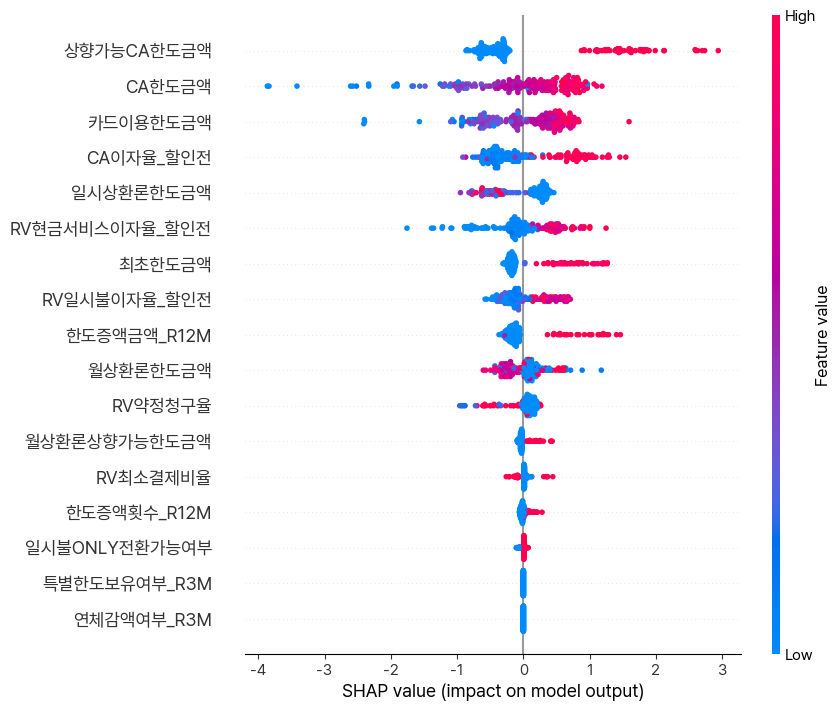

üîç SHAP beeswarm plot for Segment 1


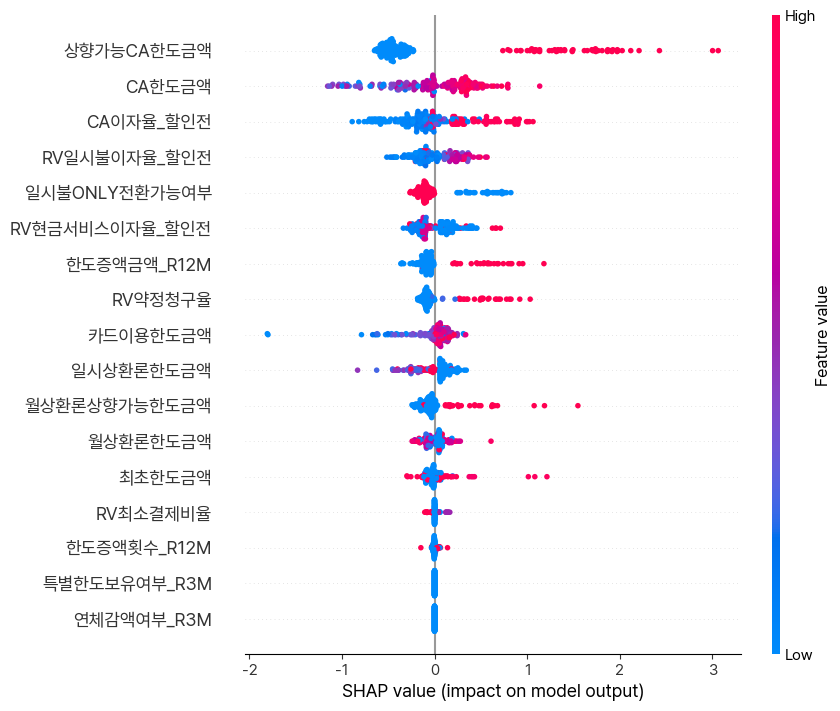

üîç SHAP beeswarm plot for Segment 2


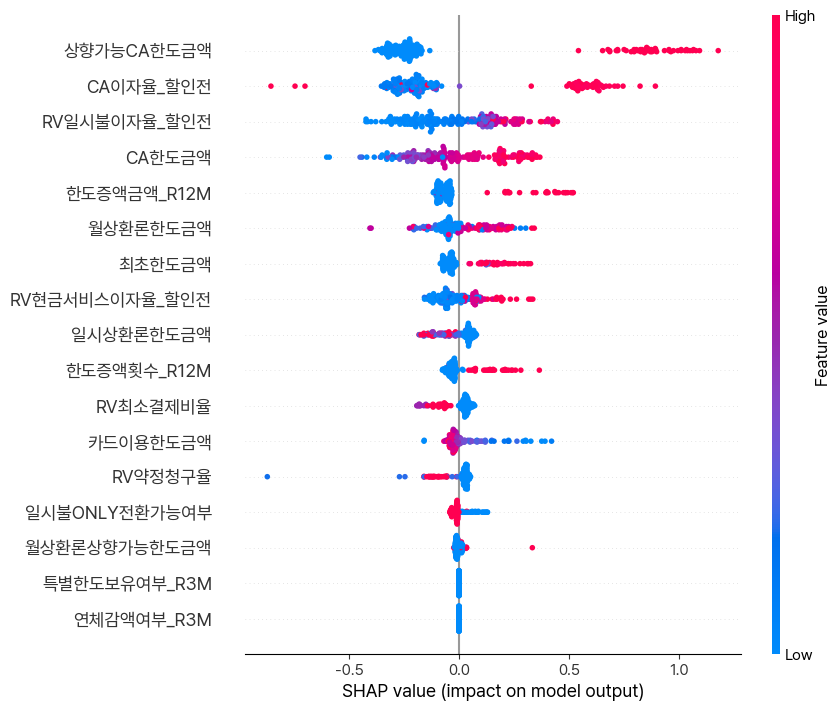

üîç SHAP beeswarm plot for Segment 3


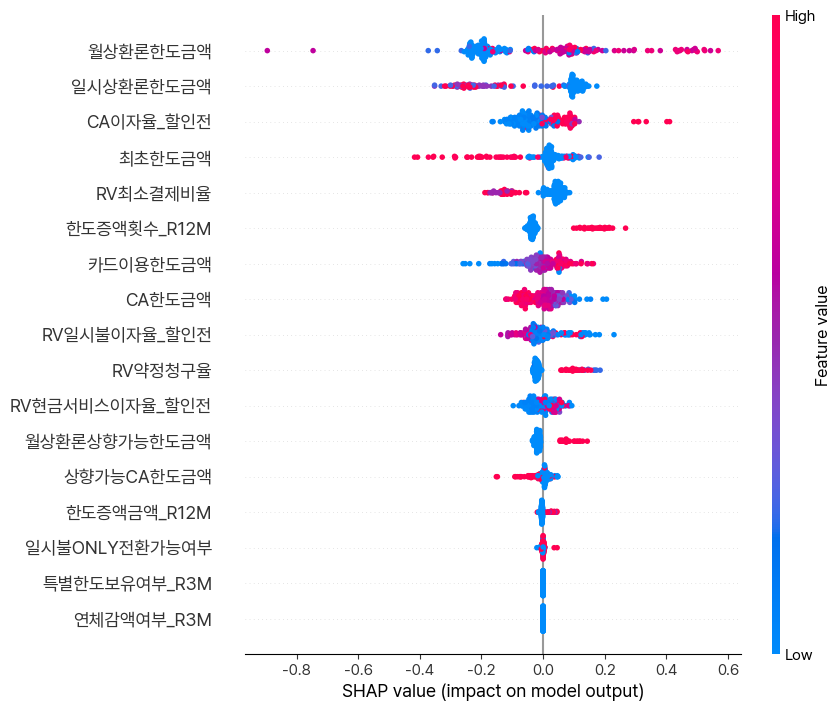

üîç SHAP beeswarm plot for Segment 4


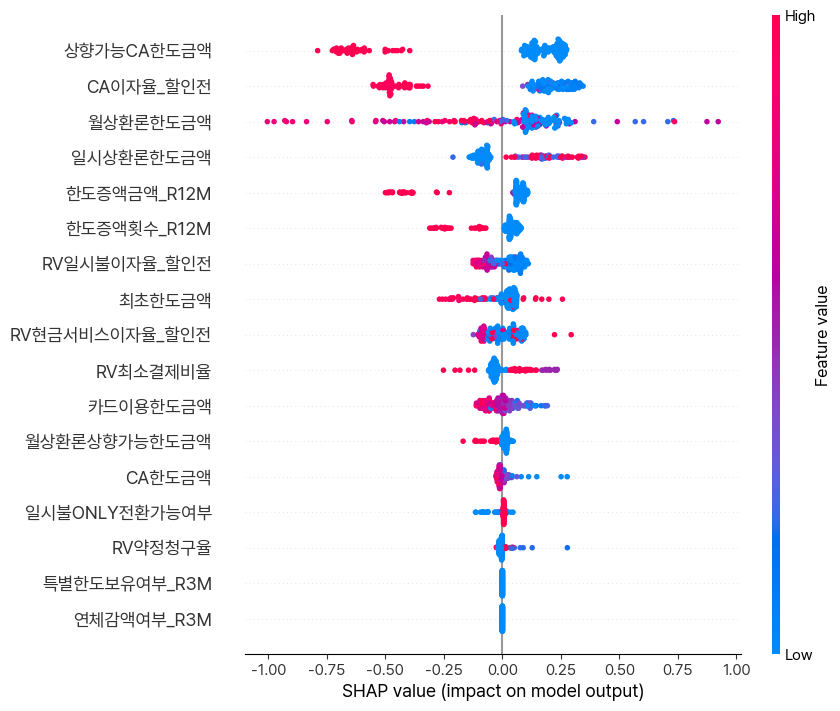

In [10]:
import shap  
import pandas as pd

# Segment 0 ÎßàÏä§ÌÇπ + Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
mask_0 = y_val == 0
X_val_df = pd.DataFrame(X_val, columns=selected_feature)
X_val_0_all = X_val_df[mask_0]

# ÏÉòÌîå Ïàò Ï°∞Ï†ï
n_samples = min(len(X_val_0_all), 300)
X_val_0 = X_val_0_all.sample(n=n_samples, random_state=42)

# SHAP Ìï¥ÏÑù
explainer = shap.Explainer(xgb_model, X_val_0)
shap_values_0 = explainer(X_val_0)

for i in range(5):  # Segment 0 ~ 4
    print(f"üîç SHAP beeswarm plot for Segment {i}")
    shap.plots.beeswarm(shap_values_0[:, :, i], max_display=20)

### ÏòÅÌñ•Î†•ÏûàÎäî Îã§Î•∏ Ïª¨Îüº ÎπÑÍµê

In [ ]:
import pandas as pd

# 1. Parquet ÌååÏùº Î∂àÎü¨Ïò§Í∏∞
file_path = "../../data/merged/ÏäπÏù∏Îß§Ï∂úÏ†ïÎ≥¥_train.parquet"
df = pd.read_parquet(file_path)

# 2. ÌÇ§ÏõåÎìúÍ∞Ä Ìè¨Ìï®Îêú Ïª¨ÎüºÎßå ÌïÑÌÑ∞ÎßÅ
keywords = ["ÌïúÎèÑÍ∏àÏï°", "Ïó∞Ï≤¥Í∞êÏï°Ïó¨Î∂Ä"]
selected_cols = [col for col in df.columns if any(k in col for k in keywords)]

# 3. ÏÑ†ÌÉùÎêú Ïª¨ÎüºÎßå Ï∂îÏ∂úÌïú Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
df_selected = df[selected_cols].copy()

# 4. Í≤∞Í≥º Ï∂úÎ†•
print(f"ÏÑ†ÌÉùÎêú Ïª¨Îüº Ïàò: {len(selected_cols)}")
print("Ïª¨Îüº Î™©Î°ù:", selected_cols)
print(df_selected.head())

ÏÑ†ÌÉùÎêú Ïª¨Îüº Ïàò: 11
Ïª¨Îüº Î™©Î°ù: ['ÏµúÏ¥àÌïúÎèÑÍ∏àÏï°', 'Ïπ¥ÎìúÏù¥Ïö©ÌïúÎèÑÍ∏àÏï°', 'CAÌïúÎèÑÍ∏àÏï°', 'ÏùºÏãúÏÉÅÌôòÎ°†ÌïúÎèÑÍ∏àÏï°', 'ÏõîÏÉÅÌôòÎ°†ÌïúÎèÑÍ∏àÏï°', 'ÏÉÅÌñ•Í∞ÄÎä•ÌïúÎèÑÍ∏àÏï°', 'ÏÉÅÌñ•Í∞ÄÎä•CAÌïúÎèÑÍ∏àÏï°', 'ÏõîÏÉÅÌôòÎ°†ÏÉÅÌñ•Í∞ÄÎä•ÌïúÎèÑÍ∏àÏï°', 'Ïπ¥ÎìúÏù¥Ïö©ÌïúÎèÑÍ∏àÏï°_B1M', 'Ïπ¥ÎìúÏù¥Ïö©ÌïúÎèÑÍ∏àÏï°_B2M', 'Ïó∞Ï≤¥Í∞êÏï°Ïó¨Î∂Ä_R3M']
   ÏµúÏ¥àÌïúÎèÑÍ∏àÏï°  Ïπ¥ÎìúÏù¥Ïö©ÌïúÎèÑÍ∏àÏï°  CAÌïúÎèÑÍ∏àÏï°  ÏùºÏãúÏÉÅÌôòÎ°†ÌïúÎèÑÍ∏àÏï°  ÏõîÏÉÅÌôòÎ°†ÌïúÎèÑÍ∏àÏï°  ÏÉÅÌñ•Í∞ÄÎä•ÌïúÎèÑÍ∏àÏï°  ÏÉÅÌñ•Í∞ÄÎä•CAÌïúÎèÑÍ∏àÏï°  \
0       0     19354    7270          0         0         0           0   
1       0      9996    5718      41996     90611         4           1   
2       0     88193   35207          0         0         0           0   
3       0     19062    6531          0         0         0           0   
4       0    177222   47149      48000    155020         0           0   

   ÏõîÏÉÅÌôòÎ°†ÏÉÅÌñ•Í∞ÄÎä•ÌïúÎèÑÍ∏àÏï°  Ïπ¥ÎìúÏù¥Ïö©ÌïúÎèÑÍ∏àÏï°_B1M  Ïπ¥ÎìúÏù¥Ïö©ÌïúÎèÑÍ∏àÏï°_B